In [626]:
import math

import pandas as pd
from pyspark.sql import SparkSession, functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, VectorIndexer
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import time

In [627]:
# Create a spark session
spark = (
    SparkSession.builder.appName("K-Means clustering test")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "4g")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

In [628]:
# these are our predictors
base_features = {'merchant_abn',
                 'consumer_id',
                 'dollar_value',
                 'postcode',
                 'gender',
                 'revenue',
                 'rate',
                 'tag'}

# TODO: address the target feature -> merchant fraud probability ting
#{'merchant_fraud_probability', 'user_fraud_probability'}
target_features = {'user_fraud_probability'}

subset = base_features.union(target_features)

In [629]:
debug = 1

In [630]:
#raw = spark.read.parquet('../../../data/curated/process_data.parquet').select(*subset)
raw = spark.read.parquet('../../../data/curated/process_data.parquet').select(*subset).sample(fraction=0.01, seed=56, withReplacement=False)

In [631]:
# try transforming dollar_value by log transform
import numpy as np

#raw = raw.withColumn('dollar_value', (F.log('dollar_value')))

# cube root?
#raw = raw.withColumn('user_fraud_probability', (F.log('user_fraud_probability')))

# 5 categories -> revenue bands should be clumped together -> they relate to take rate

raw.limit(5)

consumer_id,postcode,merchant_abn,revenue,user_fraud_probability,gender,dollar_value,rate,tag
133032,3043,14492521225,c,0.098,Female,28.52,2.5,tent and awning s...
133032,3043,63300242141,c,0.098,Female,10.36,1.62,digital goods: bo...
133032,3043,96491286698,b,0.098,Female,520.01,4.87,"furniture, home f..."
133032,3043,95574756848,a,0.098,Female,272.45,6.15,"opticians, optica..."
133032,3043,79417999332,b,0.098,Female,84.34,4.95,"gift, card, novel..."


In [632]:
# Make bins for fraud probabilities
# look at individual merchant/tag distributions
raw

consumer_id,postcode,merchant_abn,revenue,user_fraud_probability,gender,dollar_value,rate,tag
133032,3043,14492521225,c,0.098,Female,28.52,2.5,tent and awning s...
133032,3043,63300242141,c,0.098,Female,10.36,1.62,digital goods: bo...
133032,3043,96491286698,b,0.098,Female,520.01,4.87,"furniture, home f..."
133032,3043,95574756848,a,0.098,Female,272.45,6.15,"opticians, optica..."
133032,3043,79417999332,b,0.098,Female,84.34,4.95,"gift, card, novel..."
133032,3043,17488304283,a,0.098,Female,94.4,6.18,"cable, satellite,..."
1217036,4213,68004106739,a,0.26666666666666666,Male,124.74,5.61,"cable, satellite,..."
1217036,4213,82368304209,a,0.26666666666666666,Male,6471.84,5.55,telecom
1217036,4213,71674475255,b,0.26666666666666666,Male,193.4,3.81,"opticians, optica..."
1217036,4213,96161947306,b,0.26666666666666666,Male,7.75,4.52,shoe shops


In [633]:
raw.count() #13614156

136622

In [634]:
# drop missing user fraud rows
data = raw.na.drop(subset=['user_fraud_probability'])

In [635]:
data.count() #11032855 -> 2 mil or so records gone...seems less than expected

110825

In [636]:
# just making sets so its easier to understand...kinda lol
categorical_cols = {'gender', 'revenue', 'tag'}
indexed_cols = {x + '_numeric' for x in categorical_cols}
number_cols = base_features.difference(categorical_cols)

In [637]:
# just making sets so its easier to understand...kinda lol
#categorical_cols = {'gender', 'revenue', 'tag', 'postcode', 'merchant_abn', 'consumer_id'}
#indexed_cols = {x + '_numeric' for x in categorical_cols}
#number_cols = base_features.difference(categorical_cols)

Index

In [638]:
indexer = StringIndexer(inputCols=list(categorical_cols),
                        outputCols=list(indexed_cols)).fit(data)

In [639]:
df_indexed = indexer.transform(data)

Vector Index other features

In [640]:
#vindexer = VectorIndexer(inputCols=list(categorical_cols),
#                        outputCols=list(indexed_cols)).fit(data)

In [641]:
#df_indexed =

Vector Assemble

In [642]:
assembler = VectorAssembler(inputCols=list(indexed_cols.union(number_cols)),
                            outputCol='features')

In [643]:
assembled_df = assembler.transform(df_indexed)

Scale ## Look into RobustScaling

In [644]:
from pyspark.ml.feature import StandardScaler, RobustScaler

In [645]:
# standardizing the feature vector
#scale = StandardScaler(inputCol='features',outputCol='features_std').fit(assembled_df)
scale = RobustScaler(inputCol='features',outputCol='features_std').fit(assembled_df)
scaled_df = scale.transform(assembled_df)

Repartition ?

In [646]:
#scaled_df = scaled_df.repartition(100)

Train

In [647]:
(trainingData, testData) = scaled_df.randomSplit([0.7, 0.3])

In [648]:
gbt = GBTRegressor(labelCol='user_fraud_probability',
                   featuresCol="features_std",
                   maxIter=15,
                   maxDepth=10,
                   seed=8439048371454442624,
                   lossType='absolute')

# maxdepth 10 -> max iter -> 50 : 2 mins on 1%
# depth 15 iter 50 ->

In [649]:
start = time.time()
model = gbt.fit(trainingData)
print('fitting model took {0} seconds on {1} rows'.format(time.time()-start,
                                                         trainingData.count()))

22/10/03 18:00:24 WARN DAGScheduler: Broadcasting large task binary with size 1000.5 KiB
22/10/03 18:00:25 WARN DAGScheduler: Broadcasting large task binary with size 1008.0 KiB
22/10/03 18:00:25 WARN DAGScheduler: Broadcasting large task binary with size 1008.5 KiB
22/10/03 18:00:25 WARN DAGScheduler: Broadcasting large task binary with size 1009.2 KiB
22/10/03 18:00:25 WARN DAGScheduler: Broadcasting large task binary with size 1010.2 KiB
22/10/03 18:00:25 WARN DAGScheduler: Broadcasting large task binary with size 1012.5 KiB
22/10/03 18:00:25 WARN DAGScheduler: Broadcasting large task binary with size 1017.1 KiB
22/10/03 18:00:25 WARN DAGScheduler: Broadcasting large task binary with size 1026.3 KiB
22/10/03 18:00:25 WARN DAGScheduler: Broadcasting large task binary with size 1044.5 KiB
22/10/03 18:00:26 WARN DAGScheduler: Broadcasting large task binary with size 1078.1 KiB
22/10/03 18:00:26 WARN DAGScheduler: Broadcasting large task binary with size 1137.9 KiB
22/10/03 18:00:26 WAR

fitting model took 33.907386779785156 seconds on 77530 rows


Trying SVM

In [650]:
# from pyspark.ml.regression import RandomForestRegressor
# fm_model = RandomForestRegressor(labelCol='user_fraud_probability',
#                    featuresCol="features_std",
#                    maxDepth=20,
#                    seed=8439048371454442624)

In [651]:
# start = time.time()
# model = fm_model.fit(trainingData)
# print('fitting model took {0} seconds on {1} rows'.format(time.time()-start,
#                                                          trainingData.count()))

Get Predictions

In [652]:
#predictions = fm_model.transform(testData)
predictions = model.transform(testData)

In [653]:
# show some of dem
predictions.select("prediction", "user_fraud_probability", "features").show(5)

+--------------------+----------------------+--------------------+
|          prediction|user_fraud_probability|            features|
+--------------------+----------------------+--------------------+
| 0.17002962762423207|   0.09000000000000001|[226.0,6.22043989...|
|  0.6028440576410505|   0.16666666666666666|[711.0,1.55604555...|
|-0.01744088165434...|   0.11666666666666665|[2002.0,4.3186523...|
| 0.17179836046509342|   0.11666666666666665|[2002.0,6.4403598...|
| 0.12854892714787877|                   0.5|[2092.0,2.0985347...|
+--------------------+----------------------+--------------------+
only showing top 5 rows



Evaluate

In [654]:
predictions.select(['prediction', 'user_fraud_probability']).describe()

summary,prediction,user_fraud_probability
count,33295,33295
mean,0.13931348024536744,0.1527515752661847
stddev,0.06949013753459096,0.08980320108471007
min,-0.32845186188156195,0.08
max,0.9099235713410538,0.95


In [655]:
# we have an issue -> it is not predicting tail end fraud probabilities...

In [656]:
rmse_evaluator = RegressionEvaluator(
    labelCol="user_fraud_probability",
    predictionCol="prediction",
    metricName="rmse")
rmse = rmse_evaluator.evaluate(predictions)

mae_evaluator = RegressionEvaluator(
    labelCol="user_fraud_probability",
    predictionCol="prediction",
    metricName="mae")
mae = mae_evaluator.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print("Mean Average Error (MAE) on test data = %g" % mae)


Root Mean Squared Error (RMSE) on test data = 0.110481
Mean Average Error (MAE) on test data = 0.0731813


In [657]:
#predictions = predictions.withColumn('user_fraud_probability_un',
#                     (F.exp('user_fraud_probability'))) \
#         .withColumn('prediction_un', (F.exp('prediction')))

In [688]:
#res = predictions.select(['prediction_un', 'user_fraud_probability_un']).toPandas()
res = predictions.select(['prediction', 'user_fraud_probability']).toPandas()

In [689]:
#trues = predictions.select('user_fraud_probability').toPandas()

In [690]:
#res = predictions.select(['user_fraud_probability', 'prediction']).toPandas()

In [691]:
import seaborn as sns

In [692]:
#sns.boxplot(preds['prediction'])

In [693]:
#sns.boxplot(trues['user_fraud_probability'])

<AxesSubplot:>

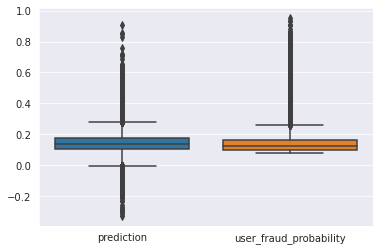

In [694]:
sns.boxplot(data=res)

In [665]:
#model.getSeed()

Inspect feature importances

In [666]:
#Source: timlrx.com/blog/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator
#import pandas as pd
def extract_feature_imp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [667]:
#extract_feature_imp(model.featureImportances, predictions, "features").round(decimals=4).head(10)

In [668]:
res

,prediction_un,user_fraud_probability_un
0,1.185340,1.094174
1,1.827308,1.181360
2,0.982710,1.123745
3,1.187438,1.123745
4,1.137177,1.648721
...,...,...
33290,1.208212,1.112563
33291,1.081066,1.112563
33292,1.351839,1.150274
33293,1.204424,1.150274


In [669]:
(res['prediction_un'] > 0.5).sum()

33295

In [670]:
(res['user_fraud_probability_un'] > 0.5).sum()

33295

The problem is the imbalanced dataset -> solutions?
* Undersample
* Oversample

Lets try undersampling

In [671]:
data.limit(5)

consumer_id,postcode,merchant_abn,revenue,user_fraud_probability,gender,dollar_value,rate,tag
133032,3043,14492521225,c,0.098,Female,28.52,2.5,tent and awning s...
133032,3043,63300242141,c,0.098,Female,10.36,1.62,digital goods: bo...
133032,3043,96491286698,b,0.098,Female,520.01,4.87,"furniture, home f..."
133032,3043,95574756848,a,0.098,Female,272.45,6.15,"opticians, optica..."
133032,3043,79417999332,b,0.098,Female,84.34,4.95,"gift, card, novel..."


In [672]:
ufp_dst = data.select('user_fraud_probability').toPandas()

/home/noahs/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='user_fraud_probability'>

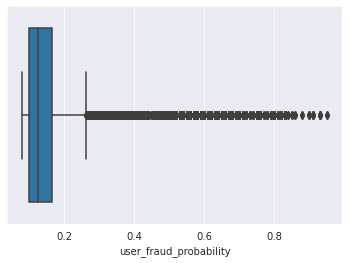

In [673]:
sns.boxplot(ufp_dst['user_fraud_probability'])

In [674]:
from pyspark.ml.feature import QuantileDiscretizer

In [675]:
steps = QuantileDiscretizer(numBuckets=10,
                            inputCol='user_fraud_probability',
                            outputCol='ufp_disretized').fit(data)

In [676]:
df_discretized = steps.transform(data)

In [677]:
df_discretized.limit(5)

consumer_id,postcode,merchant_abn,revenue,user_fraud_probability,gender,dollar_value,rate,tag,ufp_disretized
133032,3043,14492521225,c,0.098,Female,28.52,2.5,tent and awning s...,1.0
133032,3043,63300242141,c,0.098,Female,10.36,1.62,digital goods: bo...,1.0
133032,3043,96491286698,b,0.098,Female,520.01,4.87,"furniture, home f...",1.0
133032,3043,95574756848,a,0.098,Female,272.45,6.15,"opticians, optica...",1.0
133032,3043,79417999332,b,0.098,Female,84.34,4.95,"gift, card, novel...",1.0


In [678]:
ff = df_discretized.select(['user_fraud_probability', 'ufp_disretized'])

In [679]:
ff.select('ufp_disretized').groupby('ufp_disretized').count()

ufp_disretized,count
8.0,11604
0.0,4112
7.0,10317
1.0,16067
4.0,10630
3.0,11383
2.0,12611
6.0,10896
5.0,11596
9.0,11609


In [680]:
numBins = 10

In [698]:
fracs = {x : 1 / numBins for x in range(0,numBins)}
print(fracs)
#fracs2 = {0: 0.1, 1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1, 5: 0.1, 6: 0.1, 7: 0.1, 8: 0.1, 9: 0.4, 10: 0.5}

{0: 0.1, 1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1, 5: 0.1, 6: 0.1, 7: 0.1, 8: 0.1, 9: 0.1}


In [699]:
#subsample = df_discretized.sampleBy('ufp_disretized', fractions = fracs2, seed=56)
subsample = df_discretized.sampleBy('ufp_disretized', fractions = fracs, seed=56)

In [700]:
gg = subsample.select(['user_fraud_probability', 'ufp_disretized']).toPandas()

/home/noahs/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='user_fraud_probability'>

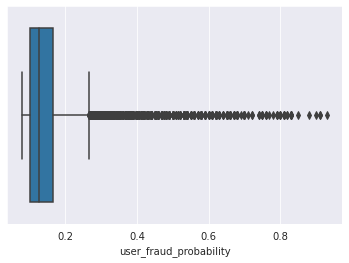

In [701]:
sns.boxplot(gg['user_fraud_probability'])

<AxesSubplot:xlabel='ufp_disretized', ylabel='user_fraud_probability'>

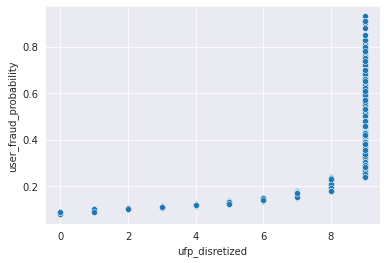

In [702]:
sns.scatterplot(x='ufp_disretized', y='user_fraud_probability', data=gg)
#sns.scatterplot(gg)

In [703]:
subsample.count()

11132

In [711]:
subsample.groupby('ufp_disretized').count()

ufp_disretized,count
8.0,1165
0.0,417
7.0,1049
1.0,1600
4.0,1077
3.0,1126
2.0,1239
6.0,1102
5.0,1182
9.0,1175


In [704]:
df_discretized.count()

110825

In [706]:
last_bin = gg[gg['ufp_disretized'] == 9]

In [707]:
last_bin.describe()

,user_fraud_probability,ufp_disretized
count,1175.000000,1175.0
mean,0.372677,9.0
std,0.136660,0.0
min,0.240000,9.0
25%,0.270000,9.0
50%,0.325000,9.0
75%,0.435625,9.0
max,0.930000,9.0


/home/noahs/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='user_fraud_probability'>

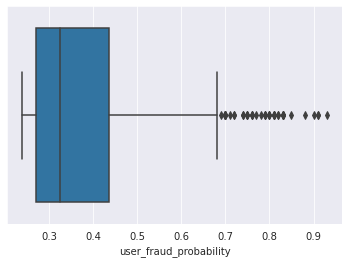

In [709]:
sns.boxplot(last_bin['user_fraud_probability'])

In [714]:
bin5 = gg[gg['ufp_disretized'] == 5]

/home/noahs/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='user_fraud_probability'>

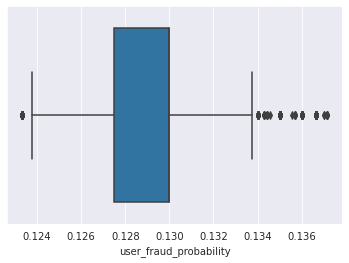

In [715]:
sns.boxplot(bin5['user_fraud_probability'])

In [716]:
import matplotlib.pyplot as plt

TypeError: 'Column' object is not callable

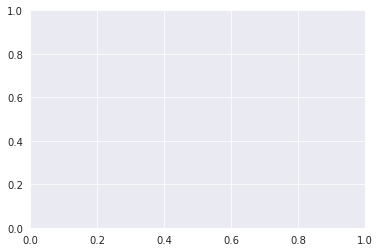

In [719]:
plt.hist(x=ff['user_fraud_probability'])

In [722]:
ff.select('user_fraud_probability').count()

110825

In [723]:
fraud_probs = ff.toPandas()

(array([3.5780e+03, 1.4610e+04, 1.4438e+04, 1.2089e+04, 1.0693e+04,
        8.4440e+03, 7.1970e+03, 2.9660e+03, 5.6140e+03, 3.9680e+03,
        3.4860e+03, 2.7830e+03, 2.3280e+03, 2.0430e+03, 2.0790e+03,
        4.6500e+02, 1.2330e+03, 1.1120e+03, 1.0550e+03, 8.9700e+02,
        8.3200e+02, 7.3000e+02, 5.6300e+02, 2.1400e+02, 5.0300e+02,
        4.7300e+02, 3.4200e+02, 3.4700e+02, 3.4600e+02, 3.4600e+02,
        9.4000e+01, 2.8700e+02, 1.9100e+02, 2.9900e+02, 2.7300e+02,
        2.0300e+02, 1.6800e+02, 2.0600e+02, 3.9000e+01, 2.0000e+02,
        2.1700e+02, 1.4700e+02, 1.7600e+02, 2.0400e+02, 1.2400e+02,
        1.6800e+02, 9.0000e+00, 1.1200e+02, 1.1800e+02, 9.8000e+01,
        1.6700e+02, 1.4200e+02, 1.0200e+02, 0.0000e+00, 5.9000e+01,
        7.4000e+01, 5.9000e+01, 6.4000e+01, 8.1000e+01, 7.2000e+01,
        5.3000e+01, 0.0000e+00, 8.8000e+01, 6.8000e+01, 3.8000e+01,
        5.0000e+01, 5.9000e+01, 5.6000e+01, 7.5000e+01, 0.0000e+00,
        2.1000e+01, 3.8000e+01, 2.7000e+01, 1.50

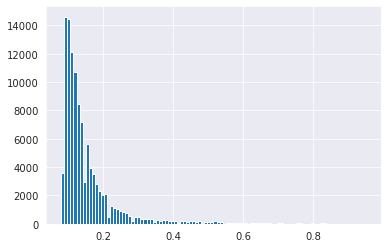

In [726]:
plt.hist(x=fraud_probs['user_fraud_probability'], bins=100)

In [727]:
import numpy as np

(array([3.5780e+03, 1.4610e+04, 1.4438e+04, 1.2089e+04, 1.0693e+04,
        8.4440e+03, 7.1970e+03, 2.9660e+03, 5.6140e+03, 3.9680e+03,
        3.4860e+03, 2.7830e+03, 2.3280e+03, 2.0430e+03, 2.0790e+03,
        4.6500e+02, 1.2330e+03, 1.1120e+03, 1.0550e+03, 8.9700e+02,
        8.3200e+02, 7.3000e+02, 5.6300e+02, 2.1400e+02, 5.0300e+02,
        4.7300e+02, 3.4200e+02, 3.4700e+02, 3.4600e+02, 3.4600e+02,
        9.4000e+01, 2.8700e+02, 1.9100e+02, 2.9900e+02, 2.7300e+02,
        2.0300e+02, 1.6800e+02, 2.0600e+02, 3.9000e+01, 2.0000e+02,
        2.1700e+02, 1.4700e+02, 1.7600e+02, 2.0400e+02, 1.2400e+02,
        1.6800e+02, 9.0000e+00, 1.1200e+02, 1.1800e+02, 9.8000e+01,
        1.6700e+02, 1.4200e+02, 1.0200e+02, 0.0000e+00, 5.9000e+01,
        7.4000e+01, 5.9000e+01, 6.4000e+01, 8.1000e+01, 7.2000e+01,
        5.3000e+01, 0.0000e+00, 8.8000e+01, 6.8000e+01, 3.8000e+01,
        5.0000e+01, 5.9000e+01, 5.6000e+01, 7.5000e+01, 0.0000e+00,
        2.1000e+01, 3.8000e+01, 2.7000e+01, 1.50

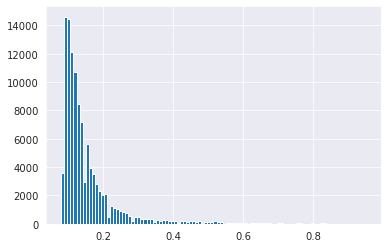

In [741]:
plt.hist(x=(fraud_probs['user_fraud_probability']), bins=100)

In [738]:
s = np.log(fraud_probs['user_fraud_probability'])

In [739]:
s

0        -2.322788
1        -2.322788
2        -2.322788
3        -2.322788
4        -2.322788
            ...   
110820   -1.714798
110821   -1.714798
110822   -1.714798
110823   -1.714798
110824   -1.714798
Name: user_fraud_probability, Length: 110825, dtype: float64

<AxesSubplot:xlabel='user_fraud_probability', ylabel='Count'>

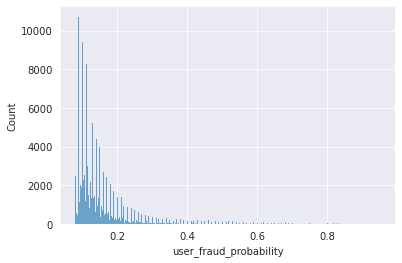

In [737]:
sns.histplot(fraud_probs['user_fraud_probability'])

In [749]:
dist_names = ['weibull_min','norm', 'weibull_max','beta', 'invgauss',
              'uniform','gamma','expon', 'lognorm' ,'pearson3','triang']
import scipy.stats as stats

In [744]:
# def get_best_distribution(data, dist_names):
#     dist_results = []
#     params = {}
#     for dist_name in dist_names:
#         dist = getattr(st, dist_name)
#         param = dist.fit(data)
#
#         params[dist_name] = param
#         # Applying the Kolmogorov-Smirnov test
#         D, p = st.kstest(data, dist_name, args=param)
#         print("p value for "+dist_name+" = "+str(p))
#         dist_results.append((dist_name, p))
#
#     # select the best fitted distribution
#     best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
#     # store the name of the best fit and its p value
#
#     print("Best fitting distribution: "+str(best_dist))
#     print("Best p value: "+ str(best_p))
#     print("Parameters for the best fit: "+ str(params[best_dist]))
#
#     return best_dist, best_p, params[best_dist]

In [ ]:
#get_best_distribution(np.array(fraud_probs['user_fraud_probability']), dist_names)

<AxesSubplot:xlabel='user_fraud_probability', ylabel='Count'>

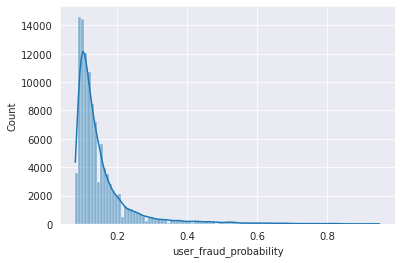

In [751]:
sns.histplot(fraud_probs['user_fraud_probability'], bins=100, kde=True)

In [752]:
from fitter import Fitter, get_common_distributions, get_distributions

In [753]:
up = np.array(fraud_probs['user_fraud_probability'])

<AxesSubplot:ylabel='Count'>

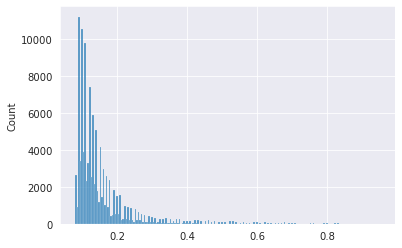

In [755]:
sns.histplot(up, bins=200)

In [756]:
f = Fitter(up,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])

In [757]:
f.fit()

Fitting 5 distributions: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
burr,25.100264,419.311679,-930088.843478,inf,0.050609,3.977520e-247
lognorm,45.366120,465.396669,-864504.559667,inf,0.058028,0.000000e+00
beta,461.216452,431.851898,-607478.477354,inf,0.249021,0.000000e+00
norm,464.577336,1985.089971,-606697.055150,inf,0.215457,0.000000e+00
gamma,504.466038,620.183291,-597556.509235,inf,0.262267,0.000000e+00


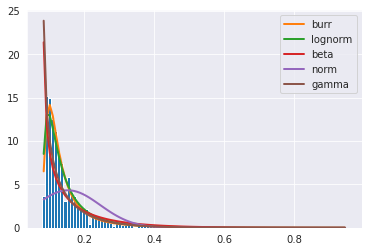

In [758]:
f.summary()

In [759]:
f.get_best(method='sumsquare_error')

{'burr': {'c': 1.8852205014674808,
  'd': 37.43686166879287,
  'loc': 0.05739301821206806,
  'scale': 0.008002279248216827}}

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
burr,25.100264,419.311679,-930088.843478,inf,0.050609,3.977520e-247
lognorm,45.366120,465.396669,-864504.559667,inf,0.058028,0.000000e+00


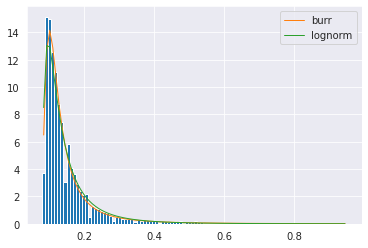

In [761]:
f.summary(Nbest=2, lw=1, plot=True, method='sumsquare_error', clf=True)